# Evaluate CheXpert models

In [1]:
import os
import numpy as np
import time
import sys
import csv
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as func
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import ToTensor,Resize
import torch.backends.cudnn as cudnn
import torchvision
import torch.optim as optim
from PIL import Image
from sklearn.metrics.ranking import roc_auc_score
import sklearn.metrics as metrics
import random

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

use_gpu = torch.cuda.is_available()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [3]:
baseFolder  = "CheXpert-v1.0-small/"

pathFileTest = baseFolder + '../validNew2.csv'

In [4]:
class LungDataset(Dataset):
    def __init__(self, baseFolder, file, transform=None, type="All"):
        image_files = []
        labels = []

        with open(file, "r") as f:
            csvReader = csv.reader(f)
            next(csvReader, None)
            k=0
            for line in csvReader:
                k+=1
                #print(line[0])
                image_file= line[0]
                if((type=="All") or (type=="Frontal" and image_file.endswith('frontal.jpg')) or (type == "Lateral" and image_file.endswith('lateral.jpg'))):
                    #Create a 14 class label with 0s and 1s for the corresponding pathologies
                    label = line[5:]

                    #Handling uncertainity
                    # TODO: Also try 0s for Us
                    for i in range(14):
                        if label[i]:
                            a = float(label[i])
                            if a == 1:
                                label[i] = 1
                            elif a == -1:
                                label[i] = 1
                            else:
                                label[i] = 0
                        else:
                            label[i] = 0       
                    #TODO: Change when running locally!    
                    image_files.append(baseFolder + image_file)
                    labels.append(label)
                    
        self.image_files = image_files
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        label = self.labels[index]
        location = self.image_files[index]
        image = Image.open(location).convert('RGB')
        
        if self.transform is not None:
            image = self.transform(image)
        return image, torch.FloatTensor(label)

    def __len__(self):
        return len(self.image_files)

In [5]:
input_size = 256
input_transforms = transforms.Compose([
            transforms.Resize((input_size, input_size)),
            #transforms.ColorJitter(brightness=.05, hue=.05, saturation=.05),
            #transformList.append(transforms.RandomHorizontalFlip()),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

In [8]:
testDataset = LungDataset('./CheXpert-v1.0-small/','./validNew2.csv', input_transforms)  

In [9]:

test_data_loader = DataLoader(testDataset, batch_size= 64, shuffle = False)

In [19]:

#Compute the roc auc score for each class separately
def class_roc_auc(data, predicted, class_count = 14):
    auroc = []
    data_np = data.cpu().numpy()
    data_np_pred = predicted.cpu().numpy()
    for i in range(class_count):
        auroc.append(roc_auc_score(data_np[:, i], data_np_pred[:, i]))
    return auroc

def test(model, test_loader, class_count, class_names):   
    out = torch.FloatTensor()
    out_pred = torch.FloatTensor()
    model.eval()
    i = 0
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(device)
            target = label
            out = torch.cat((out, target), 0)
            outV = model(image)
            out_pred = torch.cat((out_pred, outV), 0)
            print("Done" + str(i))
            i+=1
    auc_roc_class = class_roc_auc(out, out_pred, class_count)
    aurocMean = np.array(auc_roc_class).mean()

    print ('AUROC mean ', aurocMean)

    for i in range (0, len(auc_roc_class)):
        print (class_names[i], ' ', auc_roc_class[i])

    return out, out_pred

## DenseNet

In [20]:

device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

input_size = 196608

#Densenet 121 with sigmoid at the last layer 14 outputs
#Each output respresents the probability of occurence of the pathology
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.densenet = torchvision.models.densenet121(pretrained=True)
        self.densenet.classifier = nn.Sequential(
            nn.Linear(self.densenet.classifier.in_features, num_classes),
            nn.Sigmoid()
        )
        
    def forward(self,x):
        x = self.densenet(x)
        return x
model = Net(14).to(device)

In [21]:
model.load_state_dict(torch.load('densenet_5epochs.pt', map_location=device))
model = model.to(device)

In [22]:

# Class names
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
out, out_pred = test(model, test_data_loader, 14, class_names)

Done0
Done1
Done2
Done3
Done4
Done5
Done6
Done7
AUROC mean  0.795854082337
No Finding   0.893288888889
Enlarged Cardiomediastinum   0.51415245416
Cardiomegaly   0.834801819363
Lung Opacity   0.8202256232
Lung Lesion   0.760679472477
Edema   0.872825091575
Consolidation   0.76375
Pneumonia   0.748365110067
Atelectasis   0.785745460066
Pneumothorax   0.849642004773
Pleural Effusion   0.894049738361
Pleural Other   0.747451473258
Fracture   0.757982000822
Support Devices   0.89899801571


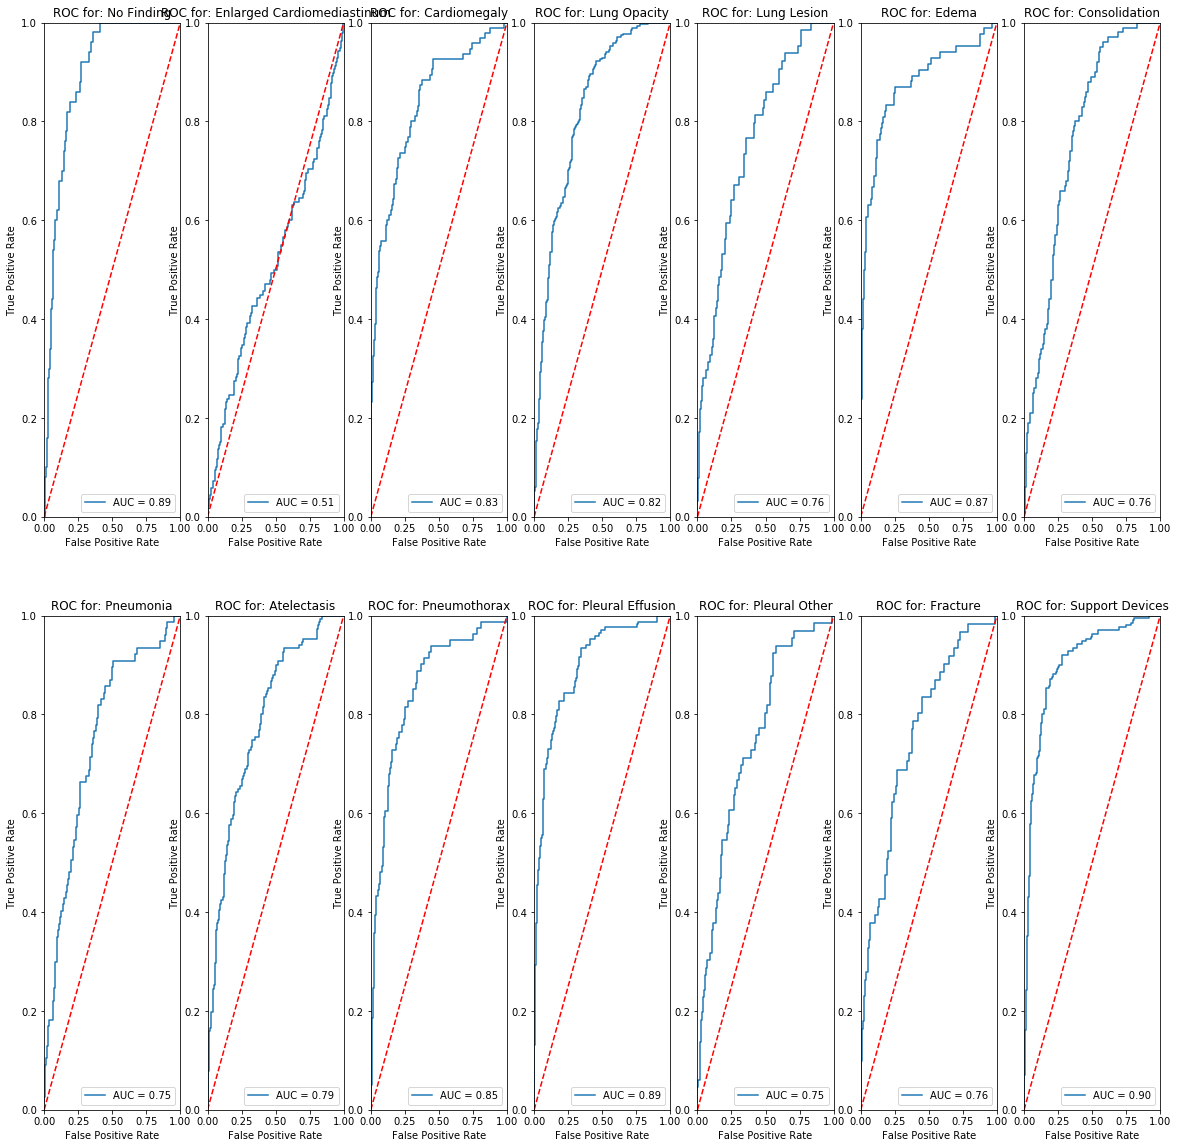

In [24]:
for i in range(14):
    fpr, tpr, threshold = metrics.roc_curve(out.cpu()[:,i], out_pred.cpu()[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    f = plt.subplot(2, 7, i+1)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 20
    fig_size[1] = 20
    plt.rcParams["figure.figsize"] = fig_size
    plt.title('ROC for: ' + class_names[i])
    plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
    
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')


plt.show()

## CNN


In [25]:

input_size = 196608
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride = 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride = 2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(4608, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256,num_classes)
        self.sigmoid = nn.Sigmoid()
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out


In [26]:
model = Net(14).to(device)

In [27]:
model.load_state_dict(torch.load('cnn_14_10epchs.pt', map_location=device))
model = model.to(device)

In [28]:

# Class names
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
out, out_pred = test(model, test_data_loader, 14, class_names)

Done0
Done1
Done2
Done3
Done4
Done5
Done6
Done7
AUROC mean  0.733675592633
No Finding   0.866844444444
Enlarged Cardiomediastinum   0.539454720154
Cardiomegaly   0.782482131254
Lung Opacity   0.757221712612
Lung Lesion   0.712586009174
Edema   0.852535485348
Consolidation   0.680875
Pneumonia   0.678609806269
Atelectasis   0.761779160895
Pneumothorax   0.696190223637
Pleural Effusion   0.83343223463
Pleural Other   0.648373132244
Fracture   0.661749878636
Support Devices   0.799324357566


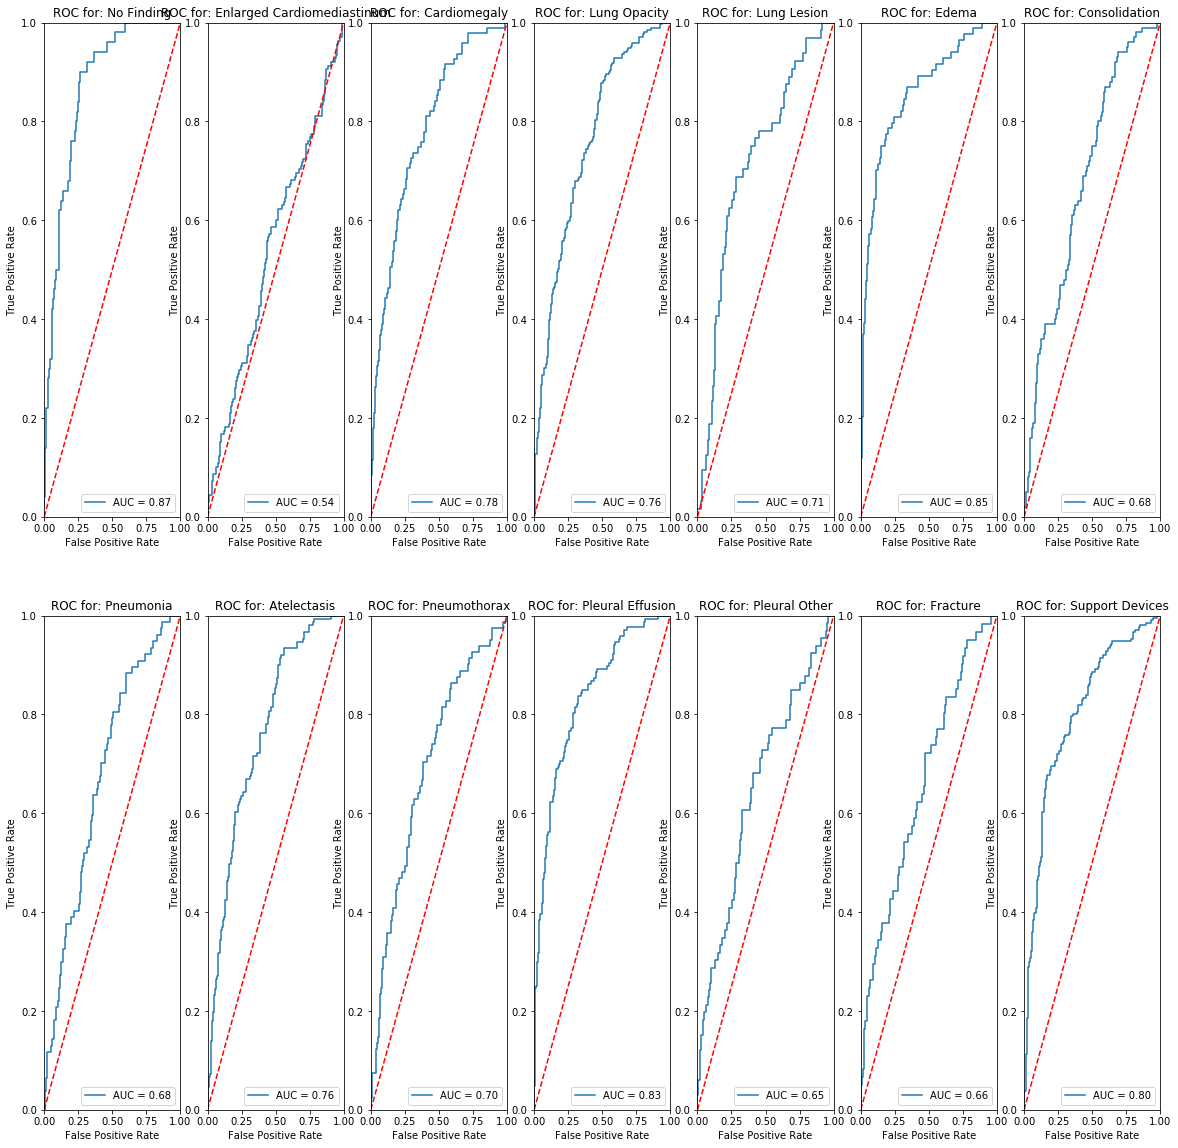

In [29]:
for i in range(14):
    fpr, tpr, threshold = metrics.roc_curve(out.cpu()[:,i], out_pred.cpu()[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    f = plt.subplot(2, 7, i+1)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 20
    fig_size[1] = 20
    plt.rcParams["figure.figsize"] = fig_size
    plt.title('ROC for: ' + class_names[i])
    plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
    
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')


plt.show()

## Separate models for frontal and lateral

In [30]:

input_size = 196608
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        
        self.densenet = torchvision.models.densenet121(pretrained=True)
        self.densenet.classifier = nn.Sequential(
            nn.Linear(self.densenet.classifier.in_features, num_classes),
            nn.Sigmoid()
        )
        
    def forward(self,x):
        x = self.densenet(x)
        return x


In [31]:
model_frontal = Net(14).to(device)

In [32]:
model_lateral = Net(14).to(device)


In [33]:
model_frontal.load_state_dict(torch.load('densenet_frontal.pt', map_location=device))
model_frontal = model_frontal.to(device)

In [34]:
model_lateral.load_state_dict(torch.load('densenet_lateral.pt', map_location=device))
model_lateral = model_lateral.to(device)

In [35]:
pathFileTest =  './validNew2.csv'

In [36]:
### Loader for getting btoh frontal images and lateral images for a study

test_df = pd.read_csv(pathFileTest)
#test_df['root'] = test_df['path']
x = test_df['Path'].str.split("/", n = 4, expand = True)
test_df['PatientStudyId'] = (x[1] + x[2])
test_df['PatientStudyId'] = test_df['PatientStudyId'].astype(str)
test_df

,Path,Sex,Age,View,AP/PA,No_Finding,Enlarged_Cardiomediastinum,Cardiomegaly,Lung_Opacity,Lung_Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture,Support_Devices,PatientStudyId
0,valid/patient64553/study1/view1_frontal.jpg,Female,61,Frontal,AP,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,patient64553study1
1,valid/patient64587/study1/view1_frontal.jpg,Male,70,Frontal,AP,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,patient64587study1
2,valid/patient64600/study1/view1_frontal.jpg,Male,62,Frontal,PA,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,patient64600study1
3,valid/patient64640/study1/view1_frontal.jpg,Female,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,patient64640study1
4,valid/patient64581/study1/view2_frontal.jpg,Male,80,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,patient64581study1
5,valid/patient64692/study1/view1_frontal.jpg,Male,42,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,patient64692study1
6,valid/patient64552/study1/view1_frontal.jpg,Female,84,Frontal,AP,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,patient64552study1
7,valid/patient64593/study1/view1_frontal.jpg,Male,60,Frontal,PA,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,patient64593study1
8,valid/patient64706/study1/view1_frontal.jpg,Female,63,Frontal,AP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,patient64706study1
9,valid/patient64685/study1/view1_frontal.jpg,Male,25,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,patient64685study1


In [37]:
frontal_df = test_df[test_df['View'] == 'Frontal']
lateral_df = test_df[test_df['View'] == 'Lateral']
combined_df = pd.merge(frontal_df, lateral_df, on='PatientStudyId', how='outer', suffixes=('_frontal', '_lateral'))
combined_df = combined_df[['Path_frontal', 'Path_lateral']]

combined_df = combined_df.where((pd.notnull(combined_df)), None)
front_lateral_dict = combined_df.set_index('Path_frontal').to_dict()
lateral_front_dict = combined_df.set_index('Path_lateral').to_dict()


In [38]:
front_lateral_dict = front_lateral_dict['Path_lateral']
lateral_front_dict = lateral_front_dict['Path_frontal']


In [39]:
from torch.autograd import Variable

class CombinedTestDataset(Dataset):
    def __init__(self, baseFolder, file,  front_lat_dict, lat_front_dict, transform=None):
        frontal_image_files = []
        lateral_image_files = []
        labels = []
        hasFrontal = []
        hasLateral = []
        with open(file, "r") as f:
            csvReader = csv.reader(f)
            next(csvReader, None)
            k=0
            for line in csvReader:
                k+=1
                #print(line[0])
                
                image_file= line[0]
                if(line[3] == 'Frontal'):
                    lateral_img_path = front_lat_dict[image_file]
                    frontal_image_files.append(baseFolder + image_file)
                    hasFrontal.append(True)
                    if(lateral_img_path is not None):
                        lateral_image_files.append(baseFolder + lateral_img_path)
                        hasLateral.append(True)
                    else:
                        lateral_image_files.append(None)
                        hasLateral.append(False)
                
                else:
                    frontal_image_path =  lat_front_dict[image_file]
                    lateral_image_files.append(baseFolder + image_file)
                    hasLateral.append(True)
                    if(frontal_image_path is not None):
                        hasFrontal.append(True)
                        frontal_image_files.append(baseFolder + frontal_image_path)
                    else:
                        hasFrontal.append(False)
                        frontal_image_files.append(None)
                
                #Create a 14 class label with 0s and 1s for the corresponding pathologies
                label = line[5:]

                #Handling uncertainity
                # TODO: Also try 0s for Us
                for i in range(14):
                    if label[i]:
                        a = float(label[i])
                        if a == 1:
                            label[i] = 1
                        elif a == -1:
                            label[i] = 1
                        else:
                            label[i] = 0
                    else:
                        label[i] = 0       
                #TODO: Change when running locally!    
                labels.append(label)
                    
        self.frontal_image_files = frontal_image_files
        self.lateral_image_files = lateral_image_files
        self.labels = labels
        self.transform = transform
        self.hasFrontal = hasFrontal
        self.hasLateral = hasLateral
        
    def __getitem__(self, index):
        label = self.labels[index]
        frontal_location = self.frontal_image_files[index]
        hasF = self.hasFrontal[index]
        hasL = self.hasLateral[index]
        
        frontal_image = None
        if(hasF):
            frontal_image = Image.open(frontal_location).convert('RGB')
            if self.transform is not None:
                frontal_image = self.transform(frontal_image)
                
        
        lateral_location = self.lateral_image_files[index]
        lateral_image = None
        if(hasL):
            lateral_image = Image.open(lateral_location).convert('RGB')
            if self.transform is not None:
                lateral_image = self.transform(lateral_image)
        hasFTensor = torch.ones([1,1])
        hasLTensor = torch.ones([1,1])
        if(frontal_image is None):
            hasFTensor = torch.zeros([1,1])
            frontal_image = lateral_image
        elif(lateral_image is None):
            hasLTensor = torch.zeros([1,1])
            lateral_image = frontal_image
        
        
        return frontal_image, lateral_image, torch.FloatTensor(label), hasFTensor, hasLTensor

    def __len__(self):
        return len(self.frontal_image_files)

In [40]:

testDataset = CombinedTestDataset('./CheXpert-v1.0-small/',pathFileTest, front_lateral_dict, lateral_front_dict, input_transforms)  

In [41]:
e = next(iter(testDataset))
e[0].size()

torch.Size([3, 256, 256])

In [42]:
test_loader = DataLoader(testDataset, batch_size= 64, shuffle = True)

In [43]:

def class_roc_auc_combined (data, predicted, class_count = 14):

    auroc = []

    data_np = data.cpu().numpy()
    data_np_pred = predicted.cpu().numpy()

    for i in range(class_count):
        auroc.append(roc_auc_score(data_np[:, i], data_np_pred[:, i]))
    return auroc



def test_combined(modelFrontal, modelLateral, test_loader, class_count, class_names):   
    out = torch.FloatTensor()
    out_pred = torch.FloatTensor()
    modelFrontal.eval()
    modelLateral.eval()
    with torch.no_grad():
        for imageF, imageL, label, hasF, hasL in test_loader:
            imageF = imageF.to(device)
            imageL = imageL.to(device)
            target = label
            out = torch.cat((out, target), 0)
            hasFSum = hasF.float().sum().data.item()
            hasLSum = hasL.float().sum().data.item()
            if hasFSum != 0 and hasLSum != 0:
                outF = modelFrontal(imageF)
                outL = modelLateral(imageL)
                outV = torch.max(outF, outL)
            elif hasLSum != 0:
                outV = modelLateral(imageL)
            else:
                outV = modelFrontal(imageF)
                
            outV = outV
            out_pred = torch.cat((out_pred, outV), 0)
    roc_auc_classes = class_roc_auc_combined(out, out_pred, class_count)
    auroc_mean = np.array(roc_auc_classes).mean()

    print ('AUROC mean ', auroc_mean)

    for i in range (class_count):
        print (class_names[i], ' ', roc_auc_classes[i])
    return out, out_pred

In [44]:

# Class names
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
out, out_pred = test_combined(model_frontal, model_lateral, test_loader, 14, class_names)

AUROC mean  0.785009601244
No Finding   0.8844
Enlarged Cardiomediastinum   0.567379293779
Cardiomegaly   0.813697205978
Lung Opacity   0.78733162748
Lung Lesion   0.789456708716
Edema   0.885073260073
Consolidation   0.741525
Pneumonia   0.726842897056
Atelectasis   0.778534697053
Pneumothorax   0.813371048057
Pleural Effusion   0.872776968585
Pleural Other   0.728669180282
Fracture   0.722954553942
Support Devices   0.878121976418


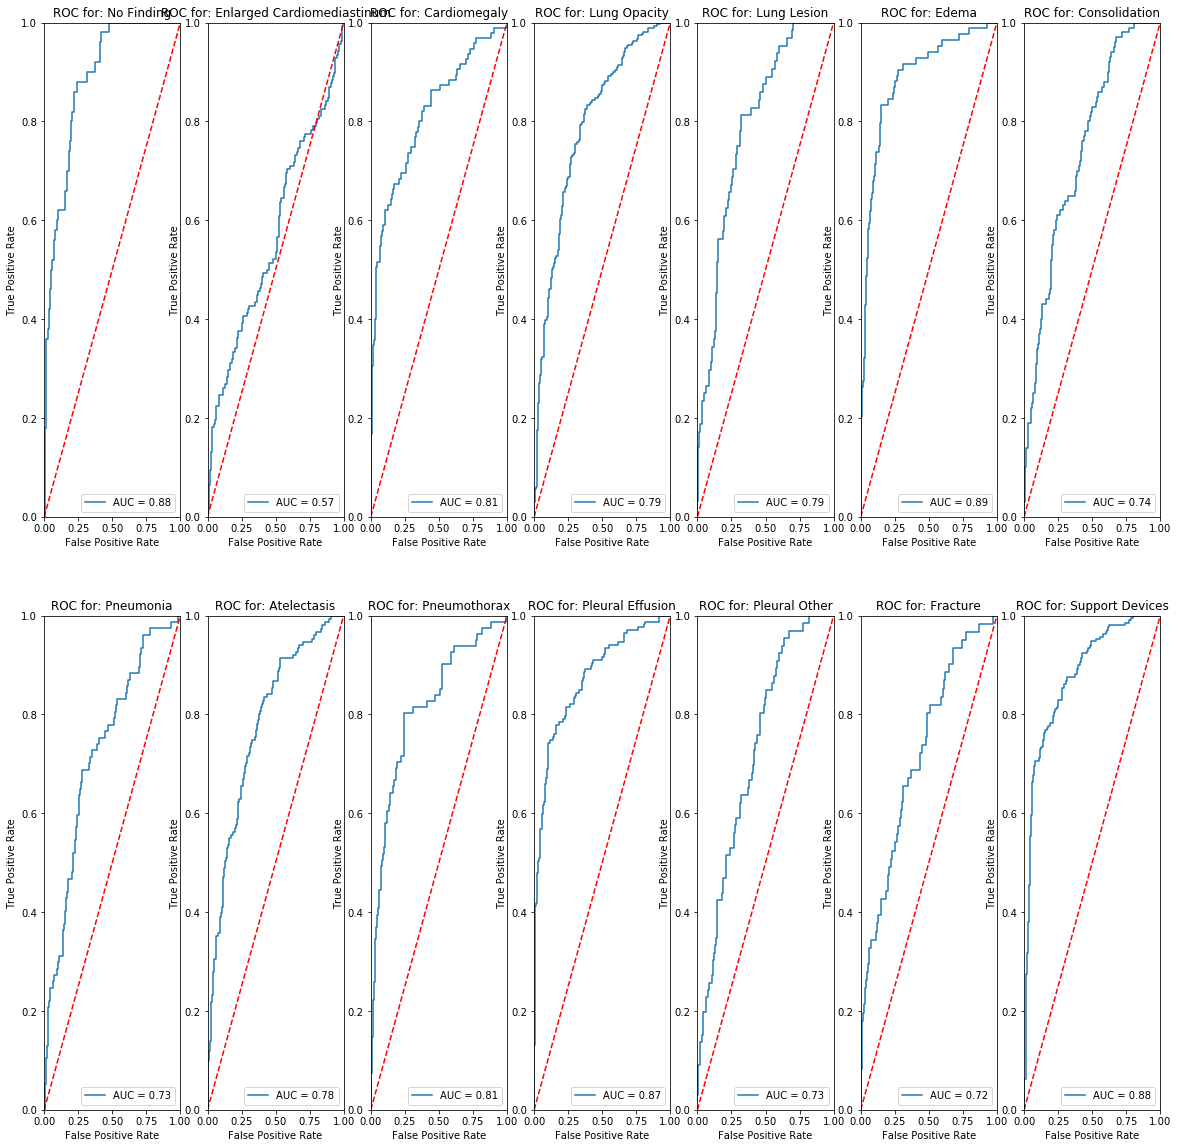

In [45]:
for i in range(14):
    fpr, tpr, threshold = metrics.roc_curve(out.cpu()[:,i], out_pred.cpu()[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    f = plt.subplot(2, 7, i+1)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 20
    fig_size[1] = 20
    plt.rcParams["figure.figsize"] = fig_size
    plt.title('ROC for: ' + class_names[i])
    plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
    
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')


plt.show()